In [1]:
import os
# Toggling between CPU and GPU
# GPU in use is NVIDIA GEFORCE 940M
# To make the GPU unavailable, uncomment the line of code below
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
# PyTorch model and training necessities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
# Image datasets and image manipulation
import torchvision
import torchvision.transforms as transforms

# Image Display
import matplotlib.pyplot as plt
import numpy as np

import sys,humanize,psutil,GPUtil

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
# PyTorch TensorBoard Support
from torch.utils.tensorboard import SummaryWriter

#default log_dir is runs
writer = SummaryWriter('runs/CIFAR')

In [5]:
# Hyperparameter (same under the hood of tensorflow)
batch_size = 10

In [6]:
# Loading Dataset and Dataloader
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


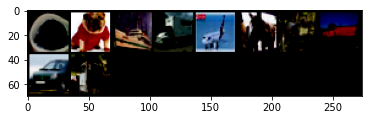

In [7]:
# Plot
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# helper function to show an image
def imshow(imgs):
    img = imgs / 2 + 0.5     # unnormalize
    npimgs = imgs.numpy()
    plt.imshow(np.transpose(npimgs, (1, 2, 0)))
    plt.show()

# get one batch random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
img_grid = torchvision.utils.make_grid(images)
imshow(img_grid)

# Path to store images for tensorboard
writer.add_image("CIFAR_images", img_grid)
#writer.flush()
writer.close()

Building the LeNet-5 Convolutional Neural Network.

In [8]:
# Model
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

images, labels = images.to(device), labels.to(device)

Define a Loss function and optimizer. 

In [9]:
# Loss and Optimizer
model = LeNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 5, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [10]:
writer.add_graph(model, images)
writer.close()

In [11]:
# Define function (For CPU) Memory Report
def cpu_mem_report():
  print("CPU RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ))

  # Getting usage of cpu virtual_memory in GB
  print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)
  # Getting % usage of cpu virtual_memory
  print('CPU RAM % used: ', psutil.virtual_memory()[2])

In [ ]:
# Define function (For GPU) Memory Report
def gpu_mem_report():
  print("CPU RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ))

  GPUs = GPUtil.getGPUs()
  for i, gpu in enumerate(GPUs):
    print('GPU {:d} ... Mem Free: {:.0f}MB / {:.0f}MB | Utilization {:3.0f}%'.format(i, gpu.memoryFree, gpu.memoryTotal, gpu.memoryUtil*100))

In [14]:
# Training
t1 = time.time()
for epoch in range(10): # loop over the dataset multiple times
    total_train_loss = 0.0
    total_test_loss = 0.0

    print ("Epoch: ", epoch)

    model.train()


    total = 0
    for idx, (image, label) in enumerate(trainloader):
        image, label = image.to(device), label.to(device)
        optimizer.zero_grad()

        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        pred = torch.nn.functional.softmax(pred, dim=1)

        for i, p in enumerate(pred):

            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1
  
    total_train_acc = total / len(trainset)
    total_train_loss = total_train_loss / (idx + 1)

    total = 0
    model.eval()
    for idx, (image, label) in enumerate(testloader):
       image, label = image.to(device), label.to(device)

       pred = model(image)
       loss = criterion(pred, label)
       total_test_loss += loss.item()
       pred = torch.nn.functional.softmax(pred, dim=1)
       for i, p in enumerate(pred):
          if label[i] == torch.max(p.data, 0)[1]:
              total = total + 1

    total_test_acc = total / len(testset)
    total_test_loss = total_test_loss / (idx + 1)

    if epoch %2 == 0: # every 2'nd epoch
    
        writer.add_scalars('Loss',
                           {'Training': total_train_loss,
                            'Testing': total_test_loss},
                            epoch)
      
        writer.add_scalars('Accuracy',
                          {'Training': total_train_acc,
                           'Testing': total_test_acc},
                           epoch)
        writer.close()
        print("Epoch: ", epoch)

    total_train_loss = 0.0
    total_test_loss = 0.0

t2 = time.time() 
print('Finished Training')
print("Training Time: ", t2-t1)
cpu_mem_report()
#gpu_mem_report()

Epoch:  0
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  8
Epoch:  9
Finished Training
Training Time:  735.7493698596954
CPU RAM Free: 3.0 GB
RAM Used (GB): 5.478731776
CPU RAM % used:  64.4


In [15]:
# Evaluation
t1 = time.time()
n_correct = 0
n_total = 0

model.eval()

with torch.no_grad():
    for (images, labels) in testloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        # take class with highest value as prediction
        _, predicted = torch.max(outputs.data, 1)

        n_total += labels.size(0)
        n_correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: {n_correct / n_total: .3f}')
t2 = time.time() 
print("Testing Time: ", t2-t1)

Accuracy on test set:  0.607
Testing Time:  9.154404163360596
